# Minería de reglas de asociación espacial sobre Minecraft

## El Proyecto
Este proyecto tiene como objetivo la aplicación de algoritmos de Inteligencia Artificial. La idea inicial consistió en buscar una solución a un problema particular que se puede explicar de la siguiente manera:

Dentro de la industria de creación de videojuegos existe un area grande e importante que consiste en la generación procedural.
Se le llama generación procedural de contenido, o **PCG** (*Procedural Content Generation*) por sus siglas en ingles, a la creación algorítmica de contenido para videojuegos con entradas del usuario limitadas o indirectas. [*Procedural Content
Generation in Games_ Noor Shaker,Julian Togelius,Mark J. Nelson*].  

Dentro de este area existen varios algoritmos que permiten la generación de contenido a partir de el establecimiento de parámetros de entrada que permiten al Diseñador orientar el funcionamiento del algoritmo. Teniendo en cuenta esta característica surge la pregunta: 
- ¿Sería posible mediante un algoritmo de inteligencia artificial y un entorno no generado artificialmente, poder *inferir* parámetros para que el algoritmo genere entornos similares?  

O de otra manera:
- ¿Puedo ***inferir las relaciones*** que existen entre los objetos de un entorno dado y, a partir de ellos, establecer parámetros para un algoritmo de generación procedural?

Debido a la extension que conllevaría realizar un proyecto para contestar estas preguntas, se decidió que el enfoque del proyecto estará en la búsqueda y comparación de algoritmos de inteligencia artificial que permitan la descripción, aprendizaje o inferencia de las relaciones que existen entre objetos en un espacio físico o virtual.

Con la exploración bibliográfica se puede entender que existe un area de investigación dentro de la ciencia en minería de datos que enfocada en como realizar las tareas de minería de datos sobre bases de datos espaciales o geográficas. La **Minería de Datos Espaciales** o **SDM** es un proceso de descubrimiento y extracción de conocimiento generalizado sobre gran cantidad de datos espaciales. [Spatial Data Mining_ Theory and Application_Deren L., Shuliang W., Deyi L]

El proyecto entonces consistirá en la aplicación de algunas técnicas y algoritmos utilizados en el area de *SDM* para realizar la inferencia de relaciones entre objetos espaciales en un entorno. Concretamente, los aplicaremos sobre un conjunto de datos extraídos del Videojuego *Minecraft*.

*Minecraft* es un videojuego 3D que utiliza un complejo procedimiento de generación procedural para la creación de terrenos de juego utilizando bloques. Se toma este escenario para la realización del proyecto debido a que los datos correspondientes a un terreno generado en el videojuego son de fácil acceso y la extracción de es sencilla, además, la disposición de los objetos dentro del juego son bloques con coordenadas rectangulares. Se puede obtener mas información sobre el procedimiento de generación procedural en está pagina web: [The World Generation of Minecraft](https://www.alanzucconi.com/2022/06/05/minecraft-world-generation/).

## Obtención de los datos del Videojuego
Para extraer la información sobre los bloques de Minecraft utilizare la información brindada por esta pagina web:[Minecraft Region file format](https://minecraft.fandom.com/wiki/Region_file_format). 

En la capeta de instalación del videojuego encontramos una carpeta donde se guarda la información cada mundo generado llamada ``saves``. Dentro de la carpeta del mundo encontramos la sub-carpeta ``region``. Esta carpeta contiene varios archivos con formato *.mca*. Los archivos *.mca* tienen un patron de nombramiento que depende de las regiones del juego que se han generado, por cada region generada existe un archivo que contiene la información de 32x32 *chunks*. Siendo *x* y *z* las coordenadas de una región los archivos se nombran como *r.x.z.mca*.

Cada *Chunk* guarda el terreno, las entidades en un area de 16x16x256 donde el ancho y largo es 16 y la altura es 256. Además guarda iluminación precomputalizada, mapas de altura y otra información que no es de nuestro interés. La estructura de los archivos .mca se ve de esta manera:  
![version 1.14 y 1.10](../../Images/mcacomparation.png)  
*(Se puede apreciar que la diferencia entre los archivos .mca nuevos y viejos no es notable en la estructura general de almacenamiento)*

El terreno que utilizare fue generado por la version 1.10.2 del videojuego. Debido a que la herramienta de [Visualización](http://pessimistress.github.io/minecraft/) funciona con mapas generados en versiones del juego anteriores a la 1.14, y el paseador de archivos *.mca* [Anvil Parser](https://github.com/matcool/anvil-parser) funciona con versiones posteriores a la 1.14. Se genera conflicto con los archivos generados por el videojuego.

Para solucionar este inconveniente y no crear un visualizador o un parcer nuevo, generé un mundo y sus correspondientes archivos *.mca* en la version 1.10 y luego **utilizando el videojuego** realizo una conversion del mapa a la version 1.14. De esta manera trabajaremos con los archivos *.mca* de la nueva version guardados en la carpeta *region_new* y visualizaremos los mapas con los archivos *.mca* guardados en la carpeta *region_old*. En escencia el **contenido de los archivos .mca es el mismo**, con la diferencia de que desde la version 1.14 cambian algunas particularidades de como se almacena la información en los archivos .mca.

Para "parsear" estos archivos y extraer la información de los bloques en un archivo de región utilizaremos la biblioteca **anvil**. Una vez parseado guardaremos el chunk en formato .csv y utilizaremos la biblioteca **pandas** para trabajar y manipular los datos.

In [1]:
#Path del CSV
csvPath = "..\\..\\Data\\chunks.csv"

In [ ]:
#Extracción de los bloques
import chunkParser
mcaPath = "..\\..\\Data\\region_new\\r.0.0.mca"
with open(csvPath,'w') as csvFile:
    chunkParser.mcaCSV(csvFile,mcaPath);

In [2]:
#Path del CSV
csvPath = "..\\..\\Data\\chunks.csv"
#Lectura del CSV
import pandas as pd
df = pd.read_csv(csvPath,delimiter=";",lineterminator="\n")
df = df.rename(columns={"ChunkX": "CX","ChunkZ\r": "CZ"}, errors="raise")
print(df)

           Bid   X    Y   Z      Tag  CX  CZ
0            1   0    0   0  bedrock   0   0
1            2   0    1   0  bedrock   0   0
2            3   0    2   0  bedrock   0   0
3            4   0    3   0    stone   0   0
4            5   0    4   0    stone   0   0
...        ...  ..  ...  ..      ...  ..  ..
1310715  65532  15  251  15      air   1   9
1310716  65533  15  252  15      air   1   9
1310717  65534  15  253  15      air   1   9
1310718  65535  15  254  15      air   1   9
1310719  65536  15  255  15      air   1   9

[1310720 rows x 7 columns]


## Análisis de Datos de Obtenidos
A diferencia de el punto de vista de la minería de datos clásica, donde el conjunto de datos esta compuesto columnas llamados Atributos y cada linea llamada transacción, al trabajar con datos espaciales cada linea se interpreta como una entidad u objeto en el espacio y cada columna puede ser un atributo no espacial o un atributo espacial.

En este caso particular podemos ver que los atributos no espaciales son el **Tag** que es prácticamente el nombre del tipo de bloque que hay en el mapa y el atributo **Bid** que es un id de bloque relativo al *chunk* en el que está.

Los demás atributos resultan ser coordenadas rectangulares donde **cx** y **cz** son coordenadas en dos dimensiones que indican la posición del *chunk* al cual pertenece el bloque. Y los atributos **(X,Y,Z)** corresponden a las coordenadas rectangulares locales que indican el posicionamiento del bloque en su *chunk*. Todos estos atributos son espaciales y describen el objeto que en este caso es un bloque.

El mapa en el juego se ve de está manera:

![top_view](../../Images/3d_views/top_view.png)
![3d_view_right](../../Images/3d_views/3d_view%20right.png)
![3d_view_left](../../Images/3d_views/3d_view%20left.png)  

Esta parte del mapa tiene algunas particularidades que son notables:
![3d_view_river](../../Images/3d_views/3d_view%20river.png)  
Se puede observar que cruza una pequeña porción de agua que esta rodeada por piedas, arena y grava. Corresponde con una pequeña parte de un río generado en el mapa.   
![3d_view_woods](../../Images/3d_views/3d_view%20Trees.png)  
La porción del terreno cubierta con arboles tiene 3 tipos: 
Los de madera clara son robles, los de madera obscura son arboles de roble obscuro y ademas se pueden observar hongos grandes rojos y uno marron.  
![3d_view_ores](../../Images/3d_views/3d_view%20ores.png)
![3d_view_caves](../../Images/3d_views/3d_view%20caves.png)  
Se pueden que en las capas inferiores pequeñas cuevas y lo que se conoce como una *grieta* en el juego. A mayor profundidad se puede observar mayor cantidad de minerales y bloques distintos a la piedra. En el ultimo nivel se puede ver que están los bloques denominados bedrock que delimitan el final del terreno y no pueden ser traspasados por los jugadores.


### Lista de tipos de bloques presentes en el conjunto de datos

In [3]:
#block tipes:
print(df["Tag"].unique())

['bedrock' 'stone' 'gold_ore' 'diorite' 'andesite' 'coal_ore' 'dirt'
 'grass_block' 'air' 'oak_log' 'oak_leaves' 'iron_ore' 'granite'
 'redstone_ore' 'lava' 'gravel' 'dark_oak_leaves' 'grass' 'cave_air'
 'dark_oak_log' 'oak_planks' 'oak_fence' 'lapis_ore' 'cobweb' 'rail'
 'poppy' 'water' 'red_mushroom_block' 'diamond_ore' 'mushroom_stem'
 'spawner' 'red_mushroom' 'infested_stone' 'emerald_ore' 'obsidian' 'sand'
 'clay' 'spruce_leaves' 'spruce_log' 'dandelion' 'brown_mushroom_block'
 'peony' 'sugar_cane' 'tall_seagrass' 'seagrass']


air                     937528
stone                   253468
dirt                     19154
diorite                  15692
bedrock                  15343
andesite                 15037
granite                  14001
cave_air                  7669
dark_oak_leaves           5970
coal_ore                  4396
grass_block               4107
gravel                    3866
oak_leaves                2815
dark_oak_log              2445
iron_ore                  2329
water                     1963
lava                      1727
redstone_ore               538
sand                       449
gold_ore                   250
grass                      247
oak_log                    247
oak_planks                 226
oak_fence                  188
red_mushroom_block         180
infested_stone             158
cobweb                     113
rail                        96
lapis_ore                   88
diamond_ore                 75
clay                        60
spruce_leaves               49
brown_mu

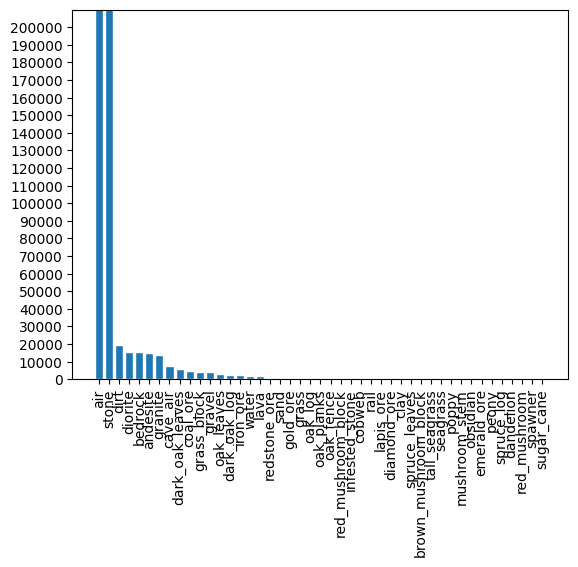

In [4]:
import matplotlib.pyplot as plt 
import numpy as np
# make data:
x = df["Tag"].value_counts().axes[0]
y = df["Tag"].value_counts()
print(y)
# plot
fig, ax = plt.subplots()

ax.bar(x, y, width=0.8, edgecolor="white")

ax.set(xticks=np.arange(0, len(x)),
       ylim=(0, 210000), yticks=np.arange(0, 210000,10000))

plt.xticks(rotation=90)
plt.show()

- Se puede observar que la mayor cantidad de bloques en el mapa son aire y piedra, y sus cantidades son en gran medida mucho mayores que los demás bloques.

### Distribución de los bloques de aire en el mapa

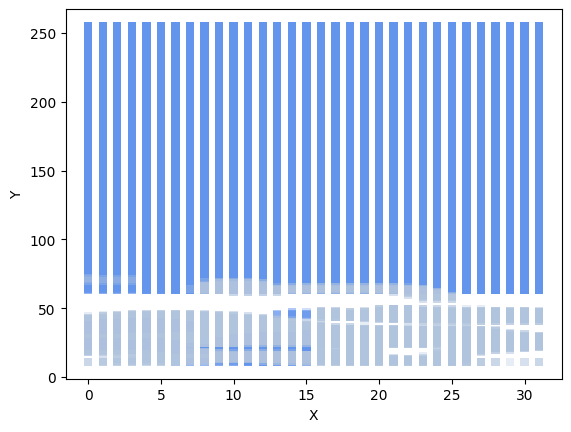

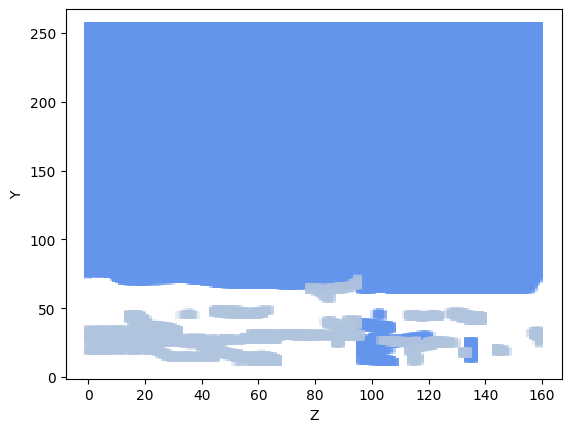

In [5]:
import matplotlib.pyplot as plt 
#Air block scatter plot
fig, ax = plt.subplots()
for lab in ["air", "cave_air"]:
    block = df[df.Tag == lab]
    x = block.X + block.CX*16 # coordenada absoluta
    y = block.Y 
    if lab == "air":
        color = "cornflowerblue"
    else:
        color = "lightsteelblue"
    ax.scatter(x, y, c=color, label=lab,
               alpha=0.3, edgecolors='none',marker="s")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


fig, ax = plt.subplots()
for lab in ["air", "cave_air"]:
    block = df[df.Tag == lab]
    z = block.Z + block.CZ*16 # coordenada absoluta
    y = block.Y 
    if lab == "air":
        color = "cornflowerblue"
    else:
        color = "lightsteelblue"
    ax.scatter(z, y, c=color, label=lab,
               alpha=0.3, edgecolors='none',marker="s")
plt.xlabel("Z")
plt.ylabel("Y")
plt.show()

- En estos gráficos podemos observar la distribución de los bloques de *aire* en azul y *aire de cueva* en color mas grisáceo. Se ve que a partir del la altura $Y = 70$ hay una gran cantidad de bloques de aire, pero también existe una pequeña porción de bloques de aire que se ubican justo en la grieta que se puede observar bajo tierra. Las demás cuevas contiene bloques de aire de cueva.

### Distribución de la lava y el agua en el mapa

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#lava and water scatter plot x and y
fig, ax = plt.subplots()
block = df
for lab in ["water", "lava"]:
    block = df[df.Tag == lab]
    x = block.X + block.CX*16 # coordenada absoluta
    y = block.Y 
    if lab == "water":
        color = "blue"
    else:
        color = "orange"
    ax.scatter(x, y, c=color, label=lab,
               alpha=0.3, edgecolors='none',marker="s")
ax.legend()
ax.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
#lava and water scatter plot z and y
fig, ax = plt.subplots()
block = df
for lab in ["water", "lava"]:
    block = df[df.Tag == lab]
    z = block.Z + block.CZ*16 # coordenada absoluta
    y = block.Y 
    if lab == "water":
        color = "blue"
    else:
        color = "orange"
    ax.scatter(z, y, c=color, label=lab,
               alpha=0.3, edgecolors='none',marker="s")
ax.legend()
ax.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
#lava and water scatter plot 3d
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

for lab in ["water", "lava"]:
    block = df[df.Tag == lab]
    x = block.Z + block.CZ*16 # coordenada absoluta
    y = block.Y 
    z = block.Z + block.CZ*16 # coordenada absoluta
    if lab == "water":
        color = "blue"
    else:
        color = "orange"
    ax.scatter(x,z,y, c=color,marker="s")
plt.xlabel("X")
plt.ylabel("Z")    
plt.show()

- Se puede Interpretar de estos gráficos que hay más lava mientras mas profundo en el mapa se esta, además hay agua en la superficie del mapa (en el río) y hay agua en algunas cuevas bajo tierra. 

### Distribución de tierra y arboles en el mapa

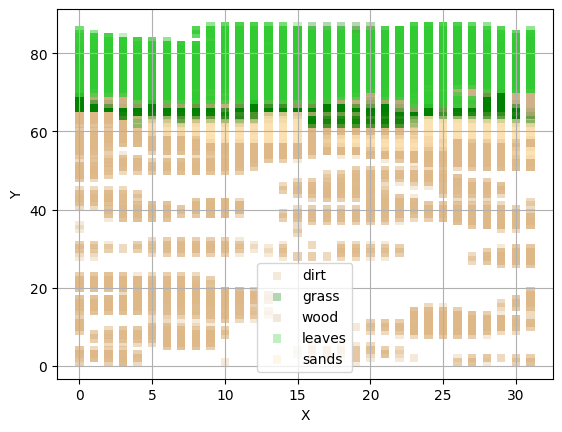

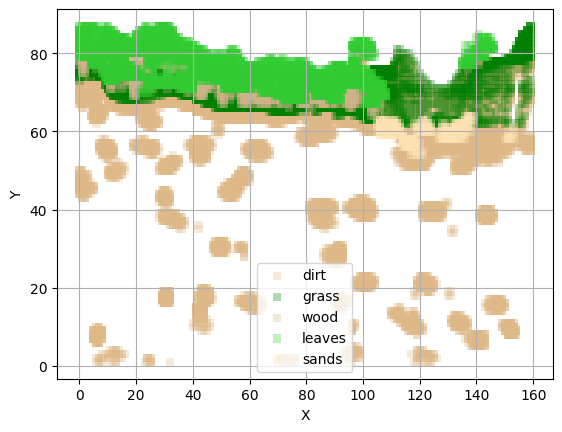

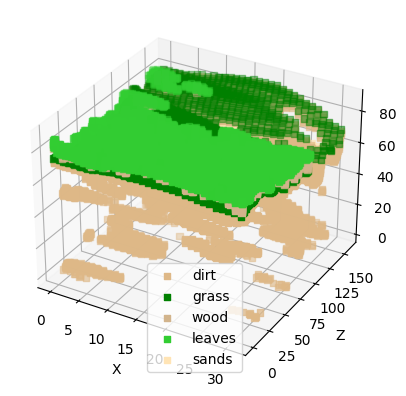

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#lava and water scatter plot x and y
#2D Plot
for dim in range(0,3):
    if(dim ==2):
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    else:
        fig, ax = plt.subplots()
    for lab in [['dirt'],['grass_block'],['oak_log','dark_oak_log','spruce_log'],['oak_leaves','dark_oak_leaves','spruce_leaves'],['sand','clay']]:
        block = df[df.Tag == lab[0]].copy()
        for i in range(1,len(lab)):
            block = block.merge(df[df.Tag == lab[i]],"outer")
        z = block.Z + block.CZ*16 # coordenada absoluta
        x = block.X + block.CX*16 # coordenada absoluta
        y = block.Y
        
        if lab[0] == "dirt":
            color = "burlywood"
            labName = "dirt"
        elif lab[0] == "grass_block":
            color = "green"
            labName = "grass"
        elif lab[0] == "oak_log":
            color = "tan"
            labName = "wood"
        elif lab[0] == "oak_leaves":
            color = "limegreen"
            labName = "leaves"
        elif lab[0] == "sand":
            color = "moccasin"
            labName = "sands"
        else:
            color = "white"
            labName = "None"
        if(dim == 0):
            ax.scatter(x, y, c=color, label=labName,alpha=0.3, edgecolors='none',marker="s")
            plt.xlabel("X")
            plt.ylabel("Y")
        elif(dim == 1):
            ax.scatter(z, y, c=color, label=labName,alpha=0.3, edgecolors='none',marker="s")
            plt.xlabel("X")
            plt.ylabel("Y")
        elif(dim == 2):
            ax.scatter(x,z,y,label=labName, c=color,marker="s")
            plt.xlabel("X")
            plt.ylabel("Z")
    ax.grid(True)
    ax.legend()
    plt.show()

- En estos gráficos podemos ver la distribución de la tierra,los arboles con sus hojas y la arena. Lo más destacable de estos gráficos es que se puede ver que los troncos y hojas de los arboles están separados del suelo y la piedra por dos capas, la primera capa consiste de los bloques con pasto, y la segunda de varios bloques de tierra, prácticamente como en la vida real. También se puede ver que donde hay arena no existen arboles por encima y también esta separada de la tierra por una capa de tierra. Finalmente la tierra se distribuye en cúmulos entre la piedra y se extiende prácticamente hasta las capas mas profundas.

## Detección de Outliers o datos espaciales apartados

Un *dato espacial aparatado* es un objeto especialmente referenciado cuyos atributos no-espaciales tienen valores que difieren significativamente de aquellos otros objetos que son vecinos.  

Existen dos tipos de metodos para la detección *valores apartados* en datos espaciales:
- **Graphical test** (Prueba gráfica): Metodos de ejemplo incluye el *variogram cloud* y el *Moran scatterplots*.
- **Quantitative test** (Prueba cuantitativa): proveen una prueba precisa para la distinción de los datos apartados. los *Scatterplots* son representativos de esta técnica.

Un **variogram-cloud** muestra puntos de datos relacionados por una relación de vecindad. por cada par de localizaciones, se plotea la raíz cuadrada de la diferencia absoluta entre los valores de los atributos de las localizaciones contra la distancia Euclideana entre las localizaciones. En conjuntos de datos que exhiben una fuerte dependencia espacial, la varianza en la diferencia entre atributos incrementara a medida que incrementa la distancia entre localizaciones.
Localizaciones que están cercanas una de la otra, pero tienen gran diferencia en sus atributos, deberían indicar un dato apartado, incluso si los valores de ambas localizaciones puedan aparentar ser razonables cuando se examinan los datos no espaciales.


In [ ]:
from outlierDetection import outilerDetection as od
atts  = df.Tag.unique().tolist();
#Cuenta la cantidad de bloques en ventanas de 4x4x4
blocks = od.countBlocks(4,4,4,df,atts);
blocks.to_csv("..\\..\\Data\\blockCount.csv",sep=";");

C:\Users\MrtC101\AppData\Local\Temp\ipykernel_19992\1510689513.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


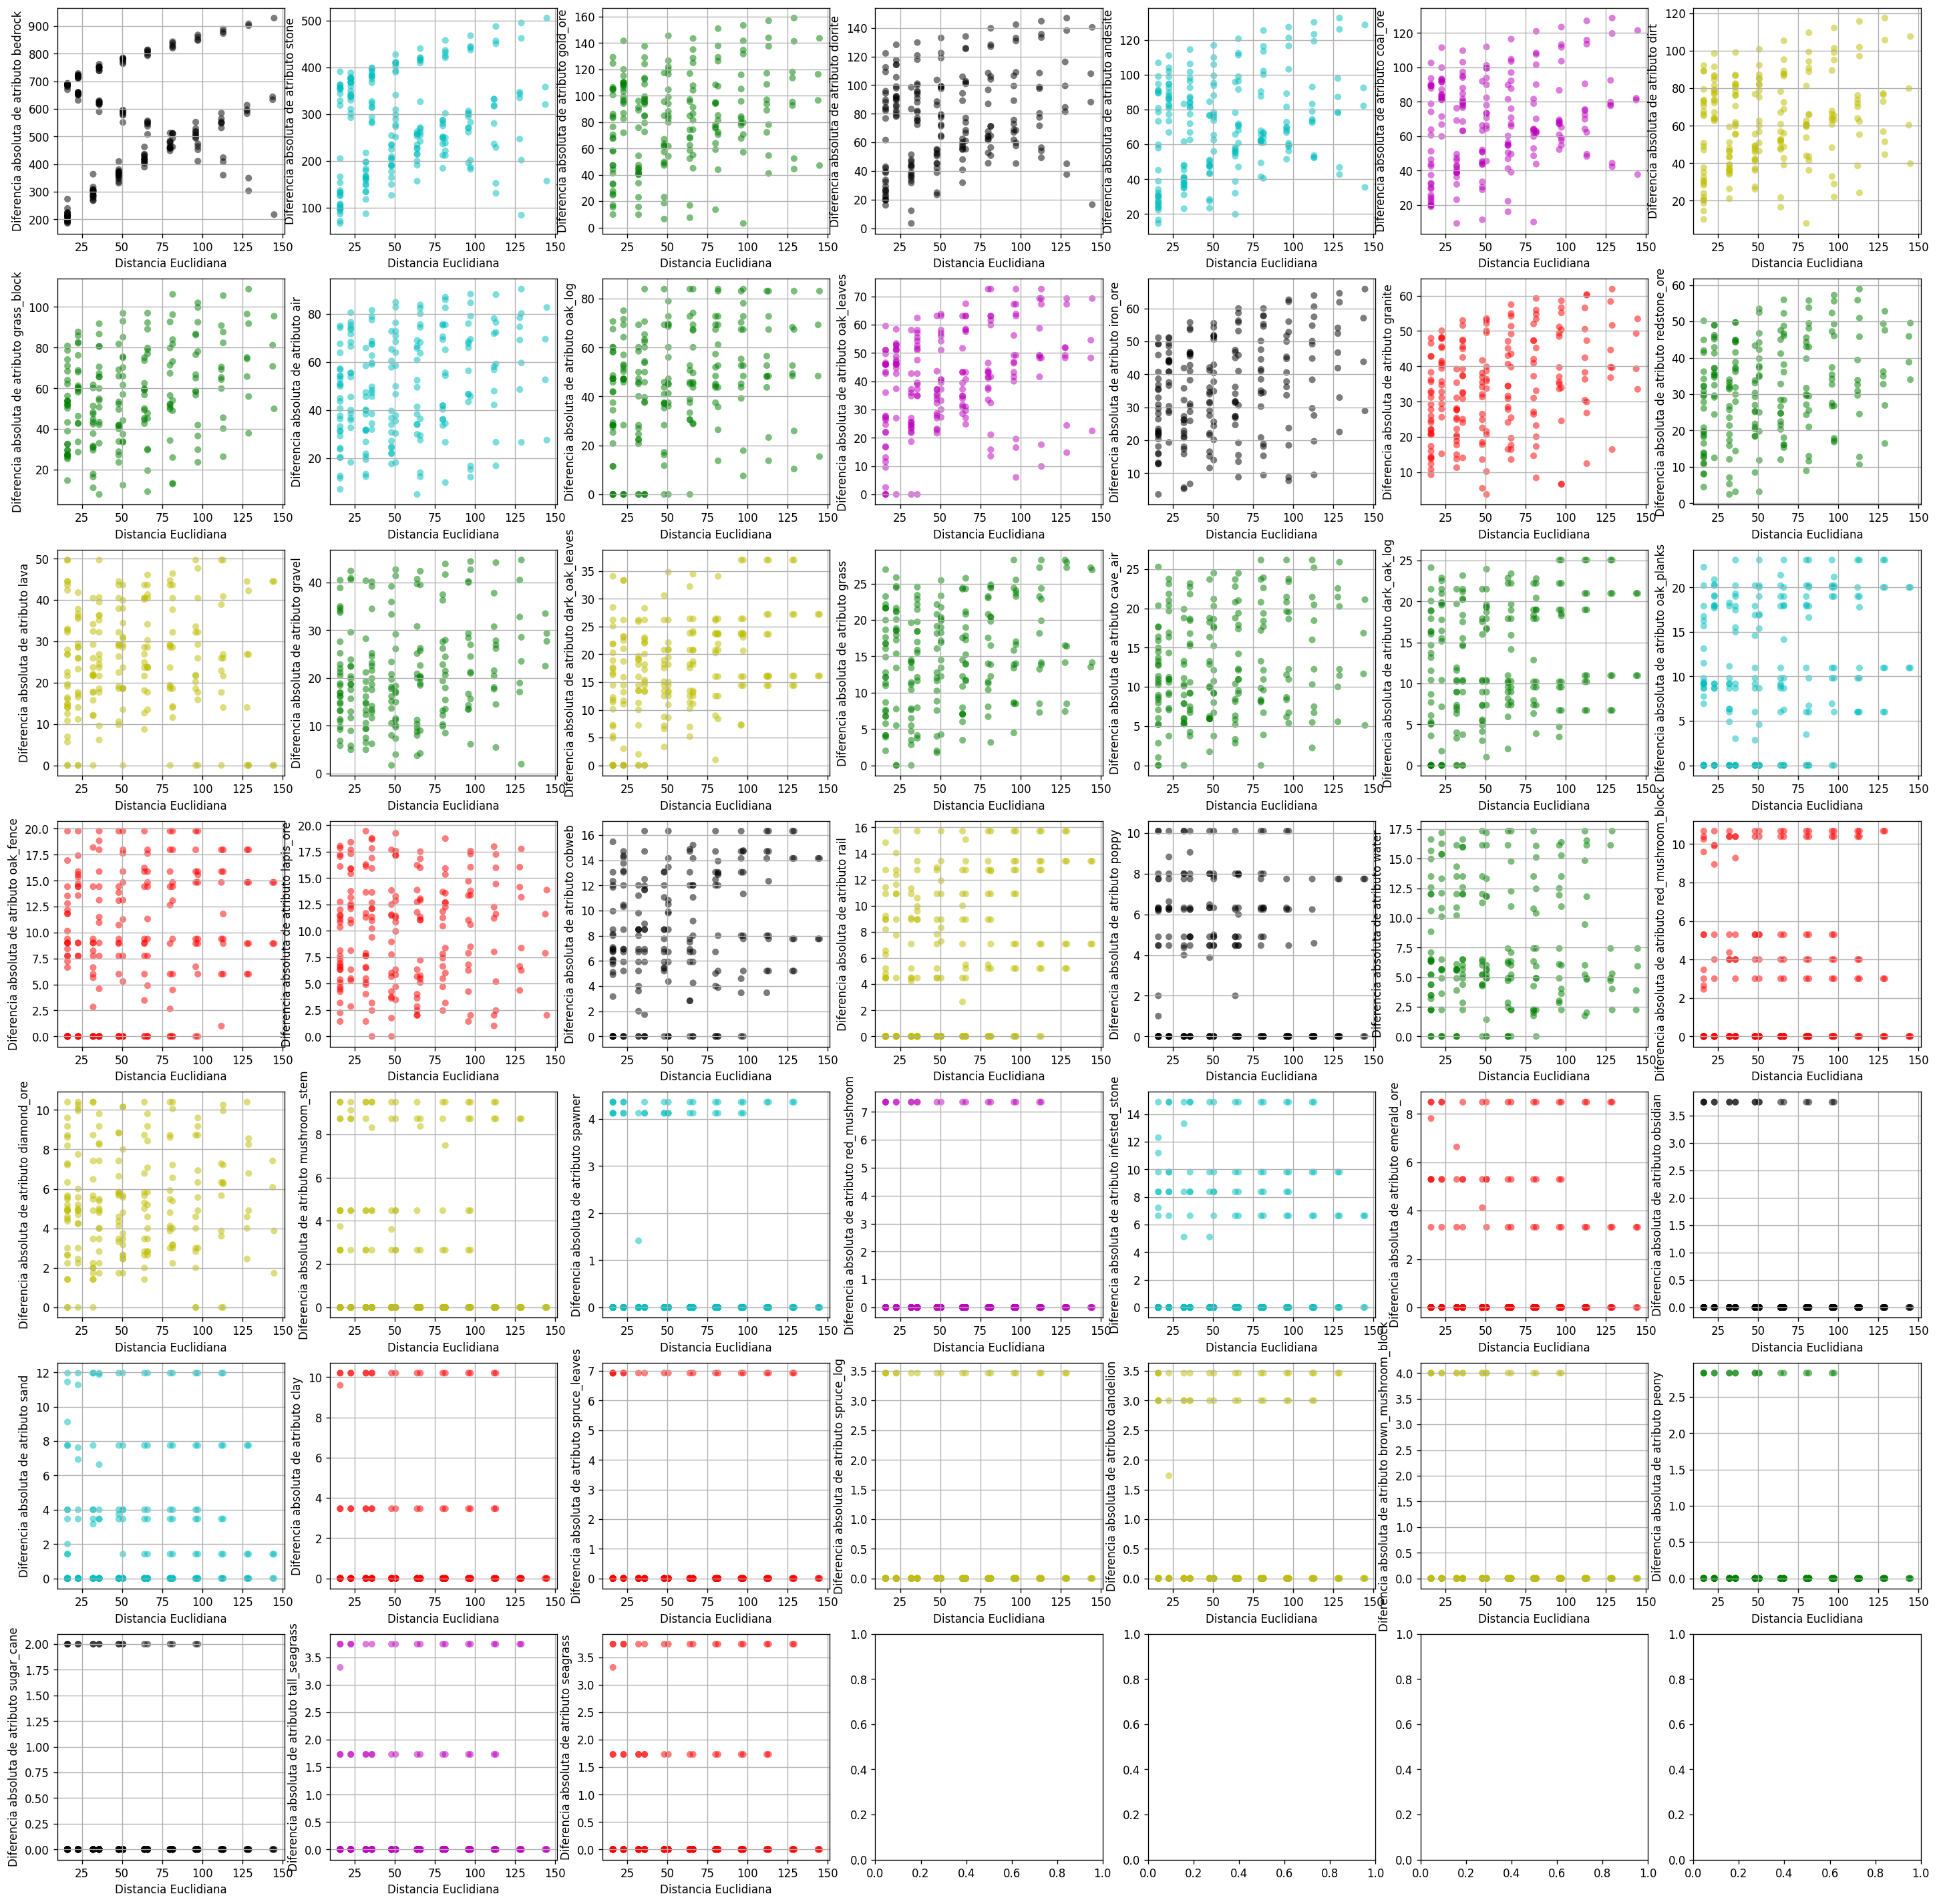

In [8]:
from outlierDetection import outilerDetection as od
import matplotlib.pyplot as plt
import pandas as pd
atts  = df.Tag.unique().tolist();
blocks = pd.read_csv("..\\..\\Data\\chunkBlockCount.csv",sep=";");
blocks = blocks.drop(blocks.columns[0],axis=1)

fig,ax = od.variogramCloud(blocks,atts);
fig.show()


Debido a que los vecindarios,ventanas o en este caso *chunks* se encuentran de manera equidistante entre si, no es util utilizar métodos que sirven para la detección de datos apartados teniendo en cuenta el espacio. En este caso podríamos decir que no trabajamos con un problema de datos espaciales. 



## Creación de transacciones a partir de datos espaciales

Muchos conjuntos de datos espaciales consisten en instancias de una colección de atributos espaciales booleano. Estos, pueden ser pensados como tipos de item, y puede que no exista un numero finito de transacciones debido a la continuidad del espacio.
En muchos problemas y ambientes existe un interés en variedad de patrones espacio-temporales incluyendo las *co-location rules* (reglas de co-localización).

Los *patrones de co-localización* representan co-ocurrencias frecuentes de subconjuntos de Atributos espaciales booleanos. 

Existen dos tipos de patrones de co-localización:  
1. **Local co-location patterns**:  Representan relaciones entre eventos en localizaciones comunes, ignorando los aspectos temporales de los datos. Estos patrones pueden encontrarse utilizando algoritmos para la clásica minería de reglas de association.
2. **Spatial co-location patterns**: Representan relaciones entre eventos sucediendo en diferentes y posibles localizaciones cercanas.

Los acercamientos a el descubrimientos de *co-location rules* en la literatura puede categorizarse en **Spatial statistics** y **association rules**. 
- Los métodos basados en **estadística espacial** utilizan medidas de correlación espacial para caracterizar las relaciones entre los diferentes tipos de atributos espaciales. Computar las medidas de correlación espacial para todo posible patron de co-localización puede ser computacionalmente caro debido al numero exponencial de candidatos dado una gran cantidad de atributos espaciales.
- El acercamiento basado en **reglas de association** se concentra en la creación de transacciones booleanas sobre el espacio de tal manera que se pueda usar el algoritmo ***apriori***.***(Estos son de nuestro interés para la resolución del problema)***

Los problemas de co-localización espacial se ven similares a los clásicos pero de hecho son diferentes debido a la ausencia de transacciones.En el problema de minería de reglas de co-localización espacial, las transacciones son implícitas y además son disjuntos en el sentido de que no comparten instancias de tipos de item. Las instancias de atributos espaciales booleanos están embebidos en el espacio y comparten una variedad de relaciones espaciales unas con otras.

### Modelos para transacciones booleanas de reglas de co-localización

Para este propósito existen diferentes modelos propuestos:
1. Una *co-location* es un subconjunto de atributos espaciales booleanos.
2. Una *co-location rule* es de la forma $C_1 \rightarrow C_2(p,cp)$ donde $C_1$ y $C_2$ son co-localizaciones,$p$ una medida de prevalencia y $cp$ es una medida de la probabilidad condicional.

Modelos:
1. **Reference feature centric model**  
Es relevante para aplicaciones enfocadas en un atributo espacial booleano. El modelo enumera los *vecindarios* para "materializar" un conjunto de transacciones al rededor de instancias del referenciado atributo espacial.
Al "materializar" transactions, el soporte y la confianza de la minería tradicional deberían ser usados como prevalencia y medidas de probabilidad condicionada.
2. **Window centric model**   
Es relevante para aplicaciones que se enfocan en land-parcels(raster). Un objetivo es predecir predecir conjuntos de atributos espaciales que es probable descubrir en una parcela dado que se han encontrado otros atributos en el.
Discretizando con un raster o grilla se generan particiones del terreno, y en este caso infinitas particiones pueden obtenerse con el solapamiento de ventanas. Nuevamente se utiliza el soporte y la confianza de la minería clásica.
3. **Event centric model**   
Es relevante para aplicaciones donde hay muchos tipos de atributos espaciales booleanos. Se utiliza cuando es de interés encontrar subconjuntos de atributos espaciales probables a ocurrir en el vecindario alrededor de instancias dado subconjuntos de tipos de eventos.
4. **Concept lattice**   
A lattice is a model for a gridded space in a spatial framework. Here the lattice refers to a countable collection of regular or irregular spatial sites related to each other via a neighborhood relationship. Several spatial statistical analyses, e.g., the spatial autoregressive model and Markov random fields, can be applied on lattice data. A Lattice Hasse diagram simply visualizes the generalization/characterization relationship between the intension and extension of a concept. Creating a Hasse diagram is similar to the process of concept classification and clustering. Compared with the Apriori algorithm, the concept lattice reduces the number of association rules by decreasing the quantity of the frequent itemsets and helps generate non-redundant rules by using a productive
subset of the frequent closed itemsets.
5. **Cloud model**   
In general, the frequent itemset association rules exist at a high conceptual level, and it is difficult to uncover them at a low conceptual level. In particular, when the attribute is numeric and the mining is on the original conceptual
level, strong association rules will not be generated if min_sup and the min_conf are larger, while many uninteresting rules will be produced if the thresholds are relatively smaller. In this case, the attribute needs to be elevated to a higher
conceptual level via attribute generalization, and then the association rules are extracted from the generalized data. The cloud model flexibly partitions the attribute space by simulating human language. Every attribute is treated as a linguistic variable that sometimes is represented with two or more attributes, which is
regarded as a multidimensional linguistic variable.
6. **Existen otros**

De todos los anteriores modelos, para este caso de aplicaciones solo 2 son de nuestro interés. El **Windows centric model** que nos resulta de muy fácil aplicación debido a que el mapa del videojuego ya se encuentra grillado en 3 dimensiones. Y (de manera tentativa), el **Cloud model** debido a que nos permite de alguna manera tomar el dominio de las coordinas rectangulares y generar expresarlo en lenguaje natural.

En principio como el mapa del juego esta grillado con coordenadas rectangulares y ademas esta subdividido en *chunks*,tranquilamente se podrían utilizar como ventanas y suponer que hay vecindad entre los bloques que los componen. Aún así estas ventanas serían muy grandes y nos darían una cantidad de transacciones pequeñas. Por lo tanto lo que podemos hacer es probar el algoritmo a priori con distintos tamaños de ventas y algún caso con superposición de ventanas.

In [ ]:
#preprocesamiento Windows metric model
from preprocess import Preprocess
#TAMAÑO DE VENTANAS 4x4x4 bloques
atts  = df.Tag.unique().tolist();
transactions : pd.DataFrame = Preprocess.windowModel(4,4,4,atts,df,False,False);
print(transactions)
transactions.to_csv("..\\..\\Data\\transactions4x4x4.csv",sep=";");

## Apriori Y Metricas

### Definición formal del problema
Sea $I = \{i_1,...,i_n\}$ un conjunto de *items*.Al conjunto que contiene *k* items se le llama conjunto *k* de items. Si $A \subseteq I,B \subseteq I$ y $A \cap B = \empty$, entonces las regla de asociación es una implicación de la forma $A\ implies B$.
   
$D$ es el conjunto de datos transaccionales relevantes para la tarea de minería.Cada transacción $T$ con un identificador $TID$ es el conjunto permitiendo $T \subseteq I$.  
Un conjunto de items ***frecuente*** es uno donde la frecuencia de ocurrencia de los items no es menor que el **soporte mínimo** establecido y no menor que el numero de transaccionen de $D$.

El algoritmo *Apriori* utiliza información en conjuntos de items *frecuentes* para generar reglas de asociación.La idea básica es buscar en el conjunto de datos transaccionales varias veces para determinar los *conjuntos de items frecuentes*. Cada búsqueda después de la primera, tiene la prioridad de generar conjuntos de datos frecuentes candidato a partir del ultimo conjunto de datos frecuentes obtenido. La información a priori es utilizada para generar el primer conjunto frecuente.

### Métricas
+ Soporte: Mide la frecuencia con la que aparece en cada transacción. Se trata de la probabilidad de que aparezca X o Y en las transacciones.
$$
Support({X}\to{Y})  = \dfrac
{\text{Transaction containing X and Y}}
{\text{Total number of transactions}}
$$

+ Confianza: Mide la probabilidad de que aparezca el consecuente dado un antecedente.

$$
Confidence({X}\to{Y})  = \dfrac
{\text{Transaction containing X and Y}}
{\text{Transactions containing X}}
$$

+ Sustentación: El indicador lift expresa cuál es la proporción del soporte observado de un conjunto de productos respecto del soporte teórico de ese conjunto dado el supuesto de independencia..Un valor de lift = 1 indica que ese conjunto aparece una cantidad de veces acorde a lo esperado bajo condiciones de independencia. Un valor de lift > 1 indica que ese conjunto aparece una cantidad de veces superior a lo esperado bajo condiciones de independencia (por lo que se puede intuir que existe una relación que hace que los productos se encuentren en el conjunto más veces de lo normal). Un valor de lift < 1 indica que ese conjunto aparece una cantidad de veces inferior a lo esperado bajo condiciones de independencia (por lo que se puede intuir que existe una relación que hace que los productos no estén formando parte del mismo conjunto más veces de lo normal).

$$
Lift({X}\to{Y})  = \dfrac{Confidence({X}\to{Y})}{Support({X}\to{Y})}
$$


## Transacciones de ventanas de 4x4x4

In [9]:
# correr Apriori
import pandas as pd
import apriori as ap
transactions = pd.read_csv("..\\..\\Data\\transactions4x4x4.csv",sep=";");
transactions = transactions.drop(transactions.columns[0],axis=1);
rules=ap.apriori(transactions,0.25,0.1);
rules.to_csv("..\\..\\Data\\rules25x10.csv",sep=";");

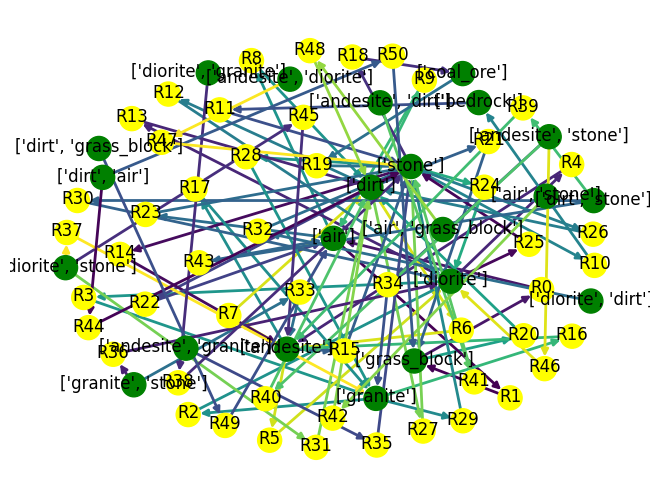

                antecedants  =>      consequents   support  confidence  \
0           ['grass_block']  =>          ['air']  0.254688    0.984894   
1                   ['air']  =>  ['grass_block']  0.254688    0.309298   
2               ['granite']  =>      ['diorite']  0.253906    0.885559   
3               ['diorite']  =>      ['granite']  0.253906    0.798526   
4               ['diorite']  =>     ['andesite']  0.276562    0.869779   
5              ['andesite']  =>      ['diorite']  0.276562    0.855072   
6                  ['dirt']  =>     ['andesite']  0.277344    0.650183   
7              ['andesite']  =>         ['dirt']  0.277344    0.857488   
8                   ['air']  =>         ['dirt']  0.289844    0.351992   
9                  ['dirt']  =>          ['air']  0.289844    0.679487   
10                ['stone']  =>      ['bedrock']  0.250000    0.569395   
11              ['bedrock']  =>        ['stone']  0.250000    1.000000   
12                 ['dirt']  =>      [

In [10]:
import pandas as pd
import apriori as ap
rules = pd.read_csv("..\\..\\Data\\rules25x10.csv",sep=";");
rules = rules.drop(rules.columns[0],axis=1);
ap.plot(rules);
print(rules)

In [1]:
#Path del CSV
csvPath = "..\\..\\Data\\chunks.csv"
#Lectura del CSV
import pandas as pd
df = pd.read_csv(csvPath,delimiter=";",lineterminator="\n")
df = df.rename(columns={"ChunkX": "CX","ChunkZ\r": "CZ"}, errors="raise")
print(df)

           Bid   X    Y   Z      Tag  CX  CZ
0            1   0    0   0  bedrock   0   0
1            2   0    1   0  bedrock   0   0
2            3   0    2   0  bedrock   0   0
3            4   0    3   0    stone   0   0
4            5   0    4   0    stone   0   0
...        ...  ..  ...  ..      ...  ..  ..
1310715  65532  15  251  15      air   1   9
1310716  65533  15  252  15      air   1   9
1310717  65534  15  253  15      air   1   9
1310718  65535  15  254  15      air   1   9
1310719  65536  15  255  15      air   1   9

[1310720 rows x 7 columns]


## Transacciones con ventanas de la forma cruz con 7 bloques
![Cruz](../../Images/Croos.png)

### Sobre bloques de diamante

In [14]:
from preprocess import Preprocess
atts  = df.Tag.unique().tolist();
list = ['diamond_ore']
transactions : pd.DataFrame = Preprocess.referenceFeatureModel(atts,df,list);
print(transactions)
transactions.to_csv("..\\..\\Data\\transactionsDiamon.csv",sep=";");

0/75
8/75
16/75
24/75
32/75
40/75
48/75
56/75
64/75
72/75
   Section SubSection  es bedrock  es stone  es gold_ore  es diorite  \
0    (0,1)  (5,13,10)       False     False        False       False   
1    (0,1)  (5,14,11)       False     False        False       False   
2    (0,1)  (6,13,10)       False     False        False       False   
3    (0,1)  (6,14,11)       False     False        False       False   
4    (0,2)    (9,5,1)       False     False        False       False   
..     ...        ...         ...       ...          ...         ...   
70   (1,8)   (15,4,5)       False     False        False       False   
71   (1,8)   (15,5,5)       False     False        False       False   
72   (1,9)    (4,4,0)       False     False        False       False   
73   (1,9)    (4,3,1)       False     False        False       False   
74   (1,9)    (4,4,1)       False     False        False       False   

    es andesite  es coal_ore  es dirt  es grass_block  ...  detrás tiene sand

In [18]:
import pandas as pd
import apriori as ap
transactions = pd.read_csv("..\\..\\Data\\transactionsDiamon.csv",sep=";");
transactions = transactions.drop(transactions.columns[0],axis=1);
rules = ap.apriori(transactions,0.50,0.90);
rules.to_csv("..\\..\\Data\\rulesDiamon50x90.csv",sep=";");

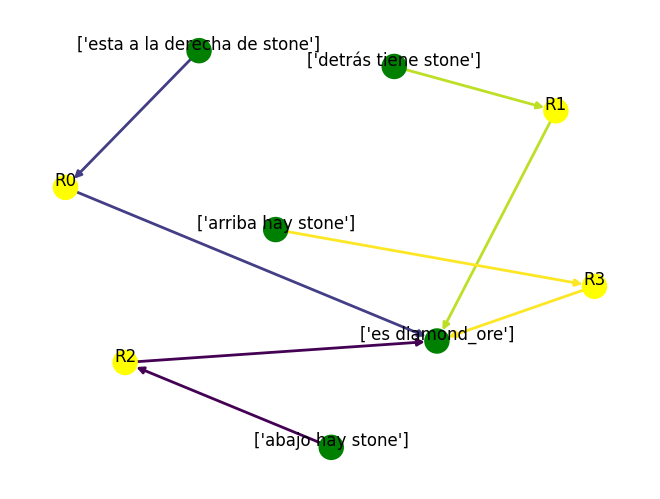

                      antecedants  =>         consequents   support  \
0  ['esta a la derecha de stone']  =>  ['es diamond_ore']  0.520000   
1          ['detrás tiene stone']  =>  ['es diamond_ore']  0.506667   
2             ['abajo hay stone']  =>  ['es diamond_ore']  0.533333   
3            ['arriba hay stone']  =>  ['es diamond_ore']  0.560000   

   confidence      lift  
0         1.0  1.923077  
1         1.0  1.973684  
2         1.0  1.875000  
3         1.0  1.785714  


In [19]:
import apriori as ap
import pandas as pd
rules = pd.read_csv("..\\..\\Data\\rulesDiamon50x90.csv",sep=";");
rules = rules.drop(rules.columns[0],axis=1);
ap.plot(rules)
print(rules)

## Sobre bloques de hojas y troncos

In [33]:
from preprocess import Preprocess
atts  = df.Tag.unique().tolist();
#intratable Arboles y hojas
trees = ["spruce_log","spruce_leaves","dark_oak_log","dark_oak_leaves","oak_log","oak_leaves"];
transactions : pd.DataFrame = Preprocess.referenceFeatureModel(atts,df,trees);
print(transactions)
transactions.to_csv("..\\..\\Data\\transactionsTrees.csv",sep=";");

['spruce_log', 'spruce_leaves', 'dark_oak_log', 'dark_oak_leaves', 'oak_log', 'oak_leaves']


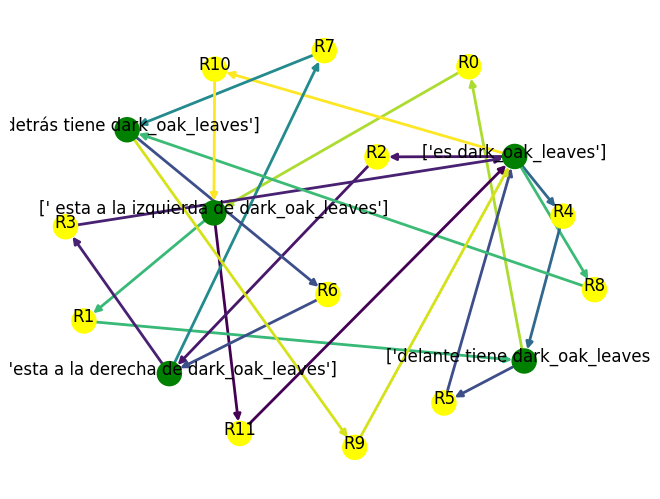

                                    antecedants  =>  \
0             ['delante tiene dark_oak_leaves']  =>   
1   [' esta a la izquierda de dark_oak_leaves']  =>   
2                        ['es dark_oak_leaves']  =>   
3      ['esta a la derecha de dark_oak_leaves']  =>   
4                        ['es dark_oak_leaves']  =>   
5             ['delante tiene dark_oak_leaves']  =>   
6              ['detrás tiene dark_oak_leaves']  =>   
7      ['esta a la derecha de dark_oak_leaves']  =>   
8                        ['es dark_oak_leaves']  =>   
9              ['detrás tiene dark_oak_leaves']  =>   
10                       ['es dark_oak_leaves']  =>   
11  [' esta a la izquierda de dark_oak_leaves']  =>   

                                    consequents   support  confidence  \
0   [' esta a la izquierda de dark_oak_leaves']  0.301622    0.732828   
1             ['delante tiene dark_oak_leaves']  0.301622    0.730672   
2      ['esta a la derecha de dark_oak_leaves']  0.377851    0.72

In [26]:
import pandas as pd
import apriori as ap
transactions = pd.read_csv("..\\..\\Data\\transactionsTrees.csv",sep=";");
transactions = transactions.drop(transactions.columns[0],axis=1);
rules = ap.apriori(transactions,0.3,0.5);
rules.to_csv("..\\..\\Data\\rulesTrees30x50.csv",sep=";");
ap.plot(rules)
print(rules)

### Sobre bloques de pasto

In [28]:
from preprocess import Preprocess
atts  = df.Tag.unique().tolist();
#intratable Arboles y hojas
print(atts)
trees = ['grass_block'];
transactions : pd.DataFrame = Preprocess.referenceFeatureModel(atts,df,trees);
print(transactions)
transactions.to_csv("..\\..\\Data\\transactionsGrass.csv",sep=";");

['bedrock', 'stone', 'gold_ore', 'diorite', 'andesite', 'coal_ore', 'dirt', 'grass_block', 'air', 'oak_log', 'oak_leaves', 'iron_ore', 'granite', 'redstone_ore', 'lava', 'gravel', 'dark_oak_leaves', 'grass', 'cave_air', 'dark_oak_log', 'oak_planks', 'oak_fence', 'lapis_ore', 'cobweb', 'rail', 'poppy', 'water', 'red_mushroom_block', 'diamond_ore', 'mushroom_stem', 'spawner', 'red_mushroom', 'infested_stone', 'emerald_ore', 'obsidian', 'sand', 'clay', 'spruce_leaves', 'spruce_log', 'dandelion', 'brown_mushroom_block', 'peony', 'sugar_cane', 'tall_seagrass', 'seagrass']


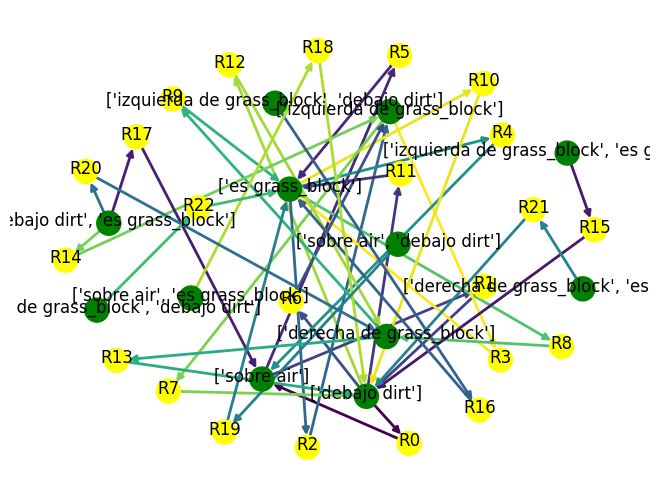

                                       antecedants  =>  \
0                                  ['debajo dirt']  =>   
1                                    ['sobre air']  =>   
2                               ['es grass_block']  =>   
3                     ['izquierda de grass_block']  =>   
4                               ['es grass_block']  =>   
5                                    ['sobre air']  =>   
6                                  ['debajo dirt']  =>   
7                     ['izquierda de grass_block']  =>   
8                               ['es grass_block']  =>   
9                       ['derecha de grass_block']  =>   
10                              ['es grass_block']  =>   
11                                 ['debajo dirt']  =>   
12                                 ['debajo dirt']  =>   
13                      ['derecha de grass_block']  =>   
14               ['debajo dirt', 'es grass_block']  =>   
15  ['izquierda de grass_block', 'es grass_block']  =>   
16     ['izqui

In [32]:
import pandas as pd
import apriori as ap
transactions = pd.read_csv("..\\..\\Data\\transactionsGrass.csv",sep=";");
transactions = transactions.drop(transactions.columns[0],axis=1);
rules = ap.apriori(transactions,0.6,0.50);
rules.to_csv("..\\..\\Data\\rulesGrass60x50.csv",sep=";");
ap.plot(rules)
print(rules)

# Resultados y reglas obtenidas

In [ ]:
#Resultados


# Bibliografía y Papers relacionados 

## Fuentes Primarias

### Data Mining

+ [Data Mining and Knowledge Discovery Handbook](https://link.springer.com/book/10.1007/b107408)

### Spatial Data Mining

+ [Spatial Data Mining_ Theory and Application_Deren L., Shuliang W., Deyi L](https://link.springer.com/book/10.1007/978-3-662-48538-5)

+ [Discovering Spatial Co-location Patterns](https://link.springer.com/chapter/10.1007/3-540-47724-1_13)

## Fuentes Secundarios

### Association Rules mining ##

+ [Métricas para reglas de association](https://towardsdatascience.com/association-rules-2-aa9a77241654)
+ [Priori en R](https://www.geeksforgeeks.org/association-rule-mining-in-r-programming/#:~:text=Association%20Rule%20Mining%20in%20R%20Language%20is%20an%20Unsupervised%20Non,in%20a%20transaction%20or%20relation.)
+ [Lista de algoritmos para minería de reglas de asociación](https://personal.ntu.edu.sg/assourav/Unpublished/UP-ARMSurvey.pdf)

### Spacial Association Rules mining ##

+ [Enhancing spatial association rule mining in geographic databases](https://www.lume.ufrgs.br/handle/10183/7841)
+ [POWERPOINT Spatial Association Rules](https://www.ismll.uni-hildesheim.de/lehre/spatial-09w/script/association_web.pdf)
+ [Papers del Power anterior](http://www.spatial.cs.umn.edu/paper_list.html)
+ [SPADA system for spatial association rules mining on spatial databases](https://edz.bib.uni-mannheim.de/www-edz/pdf/eurostat/02/KS-CS-02-001-EN-N-EN.pdf#page=26)
+ [Discovering spatial interaction patterns of near repeat crime by spatial association rules mining](https://www.nature.com/articles/s41598-020-74248-w)
+ [Exploring spatial data](https://libraries.mit.edu/files/gis/exploring_spatial_patterns_iap2013.pdf)

### Procedural generation ##

+ [DISEÑO DE ALGORITMO DE GENERACIÓN PROCEDURAL ENFOCADO A VIDEOJUEGOS](https://repositorio.usm.cl/bitstream/handle/11673/49444/3560902038911UTFSM.pdf?sequence=1&isAllowed=y)

### Minecraft related content ##

+ [The World Generation of Minecraft](https://www.alanzucconi.com/2022/06/05/minecraft-world-generation/)
+ [JS chunk visualizer](https://pessimistress.github.io/minecraft/)
+ [I Wrote a 3D Chunk Visualizer for Minecraft](https://www.youtube.com/watch?v=fpGsOdxcU2M&ab_channel=ParametricCamp)
+ [An easy to use and fast Minecraft world viewer](https://unmined.net)
+ [enkiMI Minecraft 3D editor](https://www.reddit.com/r/VoxelGameDev/comments/8c4a67/a_better_way_to_extract_minecraft_data/)
+ [Minecraft Region file format](https://minecraft.fandom.com/wiki/Region_file_format)
+ [Minecraft Region file Wikipedia](https://wiki.vg/Region_Files)
+ [Formato NBT](https://minecraft.fandom.com/es/wiki/Formato_NBT)
+ [Anvil Parser](https://github.com/matcool/anvil-parser)